# Farmers' Market and Food Insecurity


Comparing Farmers' Market Data, SNAP Data, and Population/Demographic data, maping on geography. 

Data Sources: 
- USDA Local Food Directories https://www.usdalocalfoodportal.com/fe/datasharing/
  - (API access or CSV)   
  - Farmers' Market locations = Local urban markets
  - CSA = Community Supported Agriculture, subscription or web access ie) Farm Fresh to You
  - On-Farm markets (OFM) =  Rural Markets located at the farm

- Map the Meal Gap 2019-2021
    - Child food insecurity data 
- Food Access Research Atlas 2019 https://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data/
    - SNAP benefit info per tract

- Nutrition, Physical Activity, and Obesity - Behavioral Risk Factor Surveillance System https://catalog.data.gov/nl/dataset/nutrition-physical-activity-and-obesity-behavioral-risk-factor-surveillance-system-745ae

- Census Data https://censusreporter.org/


In [1]:
# Access the data integrated in deepnote 
!ls /datasets/csausda
!ls /datasets/fmusda
!ls /datasets/nutritionhealthbehavioral
!ls /datasets/onmarketfm

csa_2022-715131859.xlsx
farmersmarket_2022-71513197.xlsx
Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv
onfarmmarket_2022-715131916.xlsx


In [255]:
# Import Libraries
!pip install xlrd openpyxl contextily geopandas mapclassify
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as ctx
import requests
from collections import defaultdict
import json

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [63]:
# Connect the USDA local food data
# listing_id, FNAP_2, FNAP, acceptedpayment_7_desc, acceptedpayment_other_desc, share_availabledate
#acceptedpayment, deliverpickup_method, location_x, location_y, location_address, listing_name

csa_data = pd.read_excel('/datasets/csausda/csa_2022-715131859.xlsx')
fm_data = pd.read_excel('/datasets/fmusda/farmersmarket_2022-71513197.xlsx')
om_data = pd.read_excel('/datasets/onmarketfm/onfarmmarket_2022-715131916.xlsx')

In [87]:
csa_data_short = csa_data[['listing_id', 'FNAP_1', 'FNAP_2', 'location_x', 'location_y', 'location_address', 'listing_name']]
fm_data_short = fm_data[['listing_id', 'FNAP_1', 'FNAP_2', 'location_x', 'location_y', 'location_address', 'listing_name']]
om_data_short = om_data[['listing_id', 'FNAP_1', 'FNAP_2', 'location_x', 'location_y', 'location_address', 'listing_name']]
 


In [88]:
print(csa_data_short.info())
print(fm_data_short.info())
print(om_data_short.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        963 non-null    int64  
 1   FNAP_1            961 non-null    float64
 2   FNAP_2            961 non-null    float64
 3   location_x        960 non-null    float64
 4   location_y        960 non-null    float64
 5   location_address  962 non-null    object 
 6   listing_name      963 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 52.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        1016 non-null   int64  
 1   FNAP_1            1002 non-null   float64
 2   FNAP_2            1002 non-null   float64
 3   location_x        1010 non-null   float64
 4   location_y  

In [89]:
"""csa_data_short = csa_data_short.dropna()
print(csa_data_short.info())
fm_data_short = fm_data_short.dropna()
print(fm_data_short.info())
"""

'csa_data_short = csa_data_short.dropna()\nprint(csa_data_short.info())\nfm_data_short = fm_data_short.dropna()\nprint(fm_data_short.info())\n'

In [90]:
csa_data_short['csa'] = 'csa'
csa_data_short['csa_bool'] = 1
fm_data_short['fm'] = 'fm'
fm_data_short['fm_bool'] = 1
om_data_short['om'] = 'om'
om_data_short['om_bool'] = 1

<ipython-input-90-1e65b739cf2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csa_data_short['csa'] = 'csa'
<ipython-input-90-1e65b739cf2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csa_data_short['csa_bool'] = 1
<ipython-input-90-1e65b739cf2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [119]:

fm_csa = fm_data_short.append(csa_data_short, ignore_index = True)
fm_csa_om = fm_csa.append(om_data_short, ignore_index = True)
fm_csa_om

,listing_id,FNAP_1,FNAP_2,location_x,location_y,location_address,listing_name,fm,fm_bool,csa,csa_bool,om,om_bool
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,fm,1.0,NaN,NaN,NaN,NaN
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,fm,1.0,NaN,NaN,NaN,NaN
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,fm,1.0,NaN,NaN,NaN,NaN
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,fm,1.0,NaN,NaN,NaN,NaN
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,fm,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,NaN,NaN,NaN,NaN,om,1.0
3638,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,NaN,NaN,NaN,NaN,om,1.0
3639,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,NaN,NaN,NaN,NaN,om,1.0
3640,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,NaN,NaN,NaN,NaN,om,1.0


In [120]:
#fill nan with 0 for creating one hot
fm_csa_om['fm_bool'] = fm_csa_om['fm_bool'].fillna(0)
fm_csa_om['csa_bool'] = fm_csa_om['csa_bool'].fillna(0)
fm_csa_om['om_bool'] = fm_csa_om['om_bool'].fillna(0)
fm_csa_om

,listing_id,FNAP_1,FNAP_2,location_x,location_y,location_address,listing_name,fm,fm_bool,csa,csa_bool,om,om_bool
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,fm,1.0,NaN,0.0,NaN,0.0
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,fm,1.0,NaN,0.0,NaN,0.0
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,fm,1.0,NaN,0.0,NaN,0.0
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,fm,1.0,NaN,0.0,NaN,0.0
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,fm,1.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,NaN,0.0,NaN,0.0,om,1.0
3638,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,NaN,0.0,NaN,0.0,om,1.0
3639,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,NaN,0.0,NaN,0.0,om,1.0
3640,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,NaN,0.0,NaN,0.0,om,1.0


In [121]:
len(fm_csa_om['listing_id'].unique())

3642

In [122]:
fm_csa_om.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   listing_id        3642 non-null   int64  
 1   FNAP_1            3624 non-null   float64
 2   FNAP_2            3624 non-null   float64
 3   location_x        3627 non-null   float64
 4   location_y        3627 non-null   float64
 5   location_address  3640 non-null   object 
 6   listing_name      3642 non-null   object 
 7   fm                1016 non-null   object 
 8   fm_bool           3642 non-null   float64
 9   csa               963 non-null    object 
 10  csa_bool          3642 non-null   float64
 11  om                1663 non-null   object 
 12  om_bool           3642 non-null   float64
dtypes: float64(7), int64(1), object(5)
memory usage: 370.0+ KB


In [123]:
fm_csa_om.loc[fm_csa_om['fm'] == 'fm', 'Farmer Market Type'] = "Farmers' Market"
fm_csa_om.loc[fm_csa_om['csa'] == 'csa', 'Farmer Market Type'] = "Community Supported Agriculture"
fm_csa_om.loc[fm_csa_om['om'] == 'om', 'Farmer Market Type'] = "On Market Farmers' Market"
fm_csa_om

,listing_id,FNAP_1,FNAP_2,location_x,location_y,location_address,listing_name,fm,fm_bool,csa,csa_bool,om,om_bool,Farmer Market Type
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,fm,1.0,NaN,0.0,NaN,0.0,Farmers' Market
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,fm,1.0,NaN,0.0,NaN,0.0,Farmers' Market
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,fm,1.0,NaN,0.0,NaN,0.0,Farmers' Market
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,fm,1.0,NaN,0.0,NaN,0.0,Farmers' Market
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,fm,1.0,NaN,0.0,NaN,0.0,Farmers' Market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,NaN,0.0,NaN,0.0,om,1.0,On Market Farmers' Market
3638,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,NaN,0.0,NaN,0.0,om,1.0,On Market Farmers' Market
3639,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,NaN,0.0,NaN,0.0,om,1.0,On Market Farmers' Market
3640,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,NaN,0.0,NaN,0.0,om,1.0,On Market Farmers' Market


In [152]:
fm_csa_om = fm_csa_om.drop(['fm', 'om', 'csa'], axis = 1)
fm_csa_om = fm_csa_om.rename(columns = {'FNAP_1': "WIC", 
                                        'FNAP_2': "SNAP", 
                                        "location_x": "longitude",
                                        "location_y": "latitude"})
fm_csa_om

,listing_id,WIC,SNAP,longitude,latitude,location_address,listing_name,fm_bool,csa_bool,om_bool,Farmer Market Type,Benefit Type
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,1.0,0.0,0.0,Farmers' Market,SNAP
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,1.0,0.0,0.0,Farmers' Market,SNAP ; WIC
...,...,...,...,...,...,...,...,...,...,...,...,...
3637,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit
3638,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit
3639,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,0.0,0.0,1.0,On Market Farmers' Market,WIC
3640,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit


In [125]:
fm_csa_om.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          3642 non-null   int64  
 1   WIC                 3624 non-null   float64
 2   SNAP                3624 non-null   float64
 3   location_x          3627 non-null   float64
 4   location_y          3627 non-null   float64
 5   location_address    3640 non-null   object 
 6   listing_name        3642 non-null   object 
 7   fm_bool             3642 non-null   float64
 8   csa_bool            3642 non-null   float64
 9   om_bool             3642 non-null   float64
 10  Farmer Market Type  3642 non-null   object 
dtypes: float64(7), int64(1), object(3)
memory usage: 313.1+ KB


In [126]:
fm_csa_om.loc[fm_csa_om['SNAP'] == 1, 'pmt_snap'] = 'SNAP'
fm_csa_om.loc[fm_csa_om['SNAP'] == 0, 'pmt_snap'] = 'No SNAP Benefit'
fm_csa_om.loc[fm_csa_om['WIC'] == 1, 'pmt_wic'] = 'WIC'
fm_csa_om.loc[fm_csa_om['WIC'] == 0, 'pmt_wic'] = 'No WIC Benefit'
fm_csa_om['Benefit Type'] = fm_csa_om.pmt_snap + ' ; ' + fm_csa_om.pmt_wic
fm_csa_om.loc[
    (fm_csa_om['pmt_snap'] == 'SNAP') &
    (fm_csa_om['pmt_wic'] == 'No WIC Benefit'), 'Benefit Type'] = "SNAP"

fm_csa_om.loc[
    (fm_csa_om['pmt_snap'] == 'No SNAP Benefit') &
    (fm_csa_om['pmt_wic'] == 'WIC'), 'Benefit Type'] = "WIC"


fm_csa_om

,listing_id,WIC,SNAP,location_x,location_y,location_address,listing_name,fm_bool,csa_bool,om_bool,Farmer Market Type,pmt_snap,pmt_wic,Benefit Type
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,1.0,0.0,0.0,Farmers' Market,SNAP,No WIC Benefit,SNAP
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit,No WIC Benefit,No SNAP Benefit ; No WIC Benefit
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit,No WIC Benefit,No SNAP Benefit ; No WIC Benefit
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit,No WIC Benefit,No SNAP Benefit ; No WIC Benefit
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,1.0,0.0,0.0,Farmers' Market,SNAP,WIC,SNAP ; WIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3637,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit,No WIC Benefit,No SNAP Benefit ; No WIC Benefit
3638,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit,No WIC Benefit,No SNAP Benefit ; No WIC Benefit
3639,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit,WIC,WIC
3640,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit,No WIC Benefit,No SNAP Benefit ; No WIC Benefit


In [129]:
fm_csa_om = fm_csa_om.drop(['pmt_snap', 'pmt_wic'], axis = 1)
fm_csa_om = fm_csa_om.dropna()
fm_csa_om.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3612 entries, 0 to 3641
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          3612 non-null   int64  
 1   WIC                 3612 non-null   float64
 2   SNAP                3612 non-null   float64
 3   location_x          3612 non-null   float64
 4   location_y          3612 non-null   float64
 5   location_address    3612 non-null   object 
 6   listing_name        3612 non-null   object 
 7   fm_bool             3612 non-null   float64
 8   csa_bool            3612 non-null   float64
 9   om_bool             3612 non-null   float64
 10  Farmer Market Type  3612 non-null   object 
 11  Benefit Type        3612 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 366.8+ KB


In [134]:
fm_csa_om.duplicated().value_counts() # no duplicates

False    3612
dtype: int64

In [155]:
fm_csa_om.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3612 entries, 0 to 3641
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          3612 non-null   int64  
 1   WIC                 3612 non-null   float64
 2   SNAP                3612 non-null   float64
 3   longitude           3612 non-null   float64
 4   latitude            3612 non-null   float64
 5   location_address    3612 non-null   object 
 6   listing_name        3612 non-null   object 
 7   fm_bool             3612 non-null   float64
 8   csa_bool            3612 non-null   float64
 9   om_bool             3612 non-null   float64
 10  Farmer Market Type  3612 non-null   object 
 11  Benefit Type        3612 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 495.9+ KB


In [198]:
# Create geo bridge table
coords = list(zip(fm_csa_om['latitude'], fm_csa_om['longitude']))
data_bridge_dict = defaultdict(list)

for lat, long_ in coords:
    data = requests.get(f"https://geo.fcc.gov/api/census/block/find?latitude={lat}%20&longitude={long_}&censusYear=2020&showall=true&format=json")
    d = data.text
    dd = json.loads(d)

    data_bridge_dict['latitude'].append(lat)
    data_bridge_dict['longitude'].append(long_)
    data_bridge_dict['Block_FIPS'].append(dd['Block']['FIPS'])
    data_bridge_dict['bbox'].append(dd['Block']['bbox'])
    data_bridge_dict['county_name'].append(dd['County']['name'])
    data_bridge_dict['County_FIPS'].append(dd['County']['FIPS'])
    data_bridge_dict['State_FIPS'].append(dd['State']['code'])
    data_bridge_dict['State_name'].append(dd['State']['name'])


In [131]:
#fm_csa_om.to_csv('fm_csa_om.csv')

In [234]:
bridge_market_df = pd.DataFrame(data_bridge_dict)
#bridge_market_df.to_csv('bridge_market_df.csv')


,latitude,longitude,Block_FIPS,bbox,county_name,County_FIPS,State_FIPS,State_name
0,38.937716,-104.814680,080410037054015,"[-104.818646, 38.932971, -104.813136, 38.938515]",El Paso County,08041,CO,Colorado
1,30.690350,-88.045015,010970002001018,"[-88.045601, 30.689942, -88.044488, 30.690884]",Mobile County,01097,AL,Alabama
2,42.404443,-90.313530,170850204011042,"[-90.316519, 42.400989, -90.306193, 42.406228]",Jo Daviess County,17085,IL,Illinois
3,44.997274,-93.473419,270530266113004,"[-93.481636, 44.995067, -93.472153, 45.000191]",Hennepin County,27053,MN,Minnesota
4,36.000559,-78.901856,370630022002064,"[-78.902268, 36.000177, -78.901401, 36.001986]",Durham County,37063,NC,North Carolina
...,...,...,...,...,...,...,...,...
3607,45.397467,-92.408597,550959606003016,"[-92.448847, 45.395804, -92.407675, 45.408456]",Polk County,55095,WI,Wisconsin
3608,41.293562,-90.067140,170730305003032,"[-90.068503, 41.287491, -90.063344, 41.293965]",Henry County,17073,IL,Illinois
3609,42.902931,-74.393467,360570727003026,"[-74.419985, 42.901353, -74.391864, 42.925173]",Montgomery County,36057,NY,New York
3610,32.024657,-96.669370,483499704002005,"[-96.681031, 32.006678, -96.640277, 32.036285]",Navarro County,48349,TX,Texas


In [236]:
bridge_market_df = bridge_market_df.dropna()
bridge_market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3610 entries, 0 to 3611
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   latitude     3610 non-null   float64
 1   longitude    3610 non-null   float64
 2   Block_FIPS   3610 non-null   object 
 3   bbox         3610 non-null   object 
 4   county_name  3610 non-null   object 
 5   County_FIPS  3610 non-null   object 
 6   State_FIPS   3610 non-null   object 
 7   State_name   3610 non-null   object 
dtypes: float64(2), object(6)
memory usage: 253.8+ KB


In [246]:
#combine the data with bridge

combined_df = pd.merge(fm_csa_om, bridge_market_df, on = ['latitude', 'longitude'], how = 'left')
combined_df.tail(50)

,listing_id,WIC,SNAP,longitude,latitude,location_address,listing_name,fm_bool,csa_bool,om_bool,Farmer Market Type,Benefit Type,Block_FIPS,bbox,county_name,County_FIPS,State_FIPS,State_name
3630,701610,0.0,0.0,-80.071675,41.377985,"3755 Sandy Lake Rd, Sandy Lake, Pennsylvania 1...",Kepner's Produce,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,420850325051104,"[-80.089207, 41.371775, -80.069924, 41.387427]",Mercer County,42085,PA,Pennsylvania
3631,701611,0.0,0.0,-83.746991,42.693661,"10371 Parshall Rd., Fenton, Michigan 48430",Genuine Roots Farm,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,260937107001032,"[-83.761328, 42.693094, -83.742074, 42.708309]",Livingston County,26093,MI,Michigan
3632,701612,0.0,0.0,-93.422944,36.226656,"161 CR 9951 , Green Forest , Arkansas 72638",Osage Creek Farms,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,050159505023057,"[-93.460136, 36.225975, -93.405687, 36.296607]",Carroll County,05015,AR,Arkansas
3633,701613,0.0,1.0,-76.075492,38.776542,"100 North Harrison Street, Easton, Maryland 21601",Quarter Acre Farm,0.0,0.0,1.0,On Market Farmers' Market,SNAP,240419604002016,"[-76.076311, 38.776353, -76.07535, 38.776942]",Talbot County,24041,MD,Maryland
3634,701614,0.0,1.0,-96.855802,36.183214,"5900 N. West Point Road, Glencoe, Oklahoma 74032","West Point Beef and Cattle Company, LLC",0.0,0.0,1.0,On Market Farmers' Market,SNAP,401190111013049,"[-96.872325, 36.173555, -96.854383, 36.188597]",Payne County,40119,OK,Oklahoma
3635,701615,0.0,0.0,-82.820628,36.293384,"9840 Baileyton Road, Afton, Tennessee 37616",Hoodley Creek,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,470590908003025,"[-82.821275, 36.289203, -82.810167, 36.295388]",Greene County,47059,TN,Tennessee
3636,701616,0.0,0.0,-79.191254,34.921006,"250 McCormick Rd, Shannon, North Carolina 28386",Spartan Tusk and Feather Livestock,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,370939704021015,"[-79.197472, 34.913368, -79.184184, 34.930658]",Hoke County,37093,NC,North Carolina
3637,701617,0.0,1.0,-83.252581,37.581595,"12205 HWY 30 East, Jackson, Kentucky 41339",Roaring Shoals Farm,0.0,0.0,1.0,On Market Farmers' Market,SNAP,210259208001059,"[-83.293546, 37.579468, -83.224185, 37.619344]",Breathitt County,21025,KY,Kentucky
3638,701618,0.0,1.0,-84.710058,34.517395,"758 Hwy 411, Ranger, Georgia 30734",Shallow Creek Farm LLC,0.0,0.0,1.0,On Market Farmers' Market,SNAP,131299701021033,"[-84.724506, 34.504388, -84.709251, 34.522668]",Gordon County,13129,GA,Georgia
3639,701619,0.0,1.0,-90.398882,30.608250,"52059 Louisiana 40, Loranger, LA, USA","Williams Family Feeder Cattle, LLC dba High Co...",0.0,0.0,1.0,On Market Farmers' Market,SNAP,221059537013016,"[-90.415256, 30.606449, -90.398316, 30.63568]",Tangipahoa Parish,22105,LA,Louisiana


In [259]:
combined_df = combined_df.loc[combined_df.astype(str).drop_duplicates().index]
#combined_df.to_csv('final_fm_csa_om.csv', index = False)

In [260]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3612 entries, 0 to 3679
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          3612 non-null   int64  
 1   WIC                 3612 non-null   float64
 2   SNAP                3612 non-null   float64
 3   longitude           3612 non-null   float64
 4   latitude            3612 non-null   float64
 5   location_address    3612 non-null   object 
 6   listing_name        3612 non-null   object 
 7   fm_bool             3612 non-null   float64
 8   csa_bool            3612 non-null   float64
 9   om_bool             3612 non-null   float64
 10  Farmer Market Type  3612 non-null   object 
 11  Benefit Type        3612 non-null   object 
 12  Block_FIPS          3610 non-null   object 
 13  bbox                3610 non-null   object 
 14  county_name         3610 non-null   object 
 15  County_FIPS         3610 non-null   object 
 16  State_

## Visualize a Choropleth Map

In [261]:
fm_csa_om_df = pd.read_csv('/work/final_fm_csa_om.csv')
fm_csa_om_df

,listing_id,WIC,SNAP,longitude,latitude,location_address,listing_name,fm_bool,csa_bool,om_bool,Farmer Market Type,Benefit Type,Block_FIPS,bbox,county_name,County_FIPS,State_FIPS,State_name
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,1.0,0.0,0.0,Farmers' Market,SNAP,8.041004e+13,"[-104.818646, 38.932971, -104.813136, 38.938515]",El Paso County,8041.0,CO,Colorado
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit,1.097000e+13,"[-88.045601, 30.689942, -88.044488, 30.690884]",Mobile County,1097.0,AL,Alabama
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit,1.708502e+14,"[-90.316519, 42.400989, -90.306193, 42.406228]",Jo Daviess County,17085.0,IL,Illinois
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit,2.705303e+14,"[-93.481636, 44.995067, -93.472153, 45.000191]",Hennepin County,27053.0,MN,Minnesota
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,1.0,0.0,0.0,Farmers' Market,SNAP ; WIC,3.706300e+14,"[-78.902268, 36.000177, -78.901401, 36.001986]",Durham County,37063.0,NC,North Carolina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,5.509596e+14,"[-92.448847, 45.395804, -92.407675, 45.408456]",Polk County,55095.0,WI,Wisconsin
3608,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,1.707303e+14,"[-90.068503, 41.287491, -90.063344, 41.293965]",Henry County,17073.0,IL,Illinois
3609,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,0.0,0.0,1.0,On Market Farmers' Market,WIC,3.605707e+14,"[-74.419985, 42.901353, -74.391864, 42.925173]",Montgomery County,36057.0,NY,New York
3610,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,4.834997e+14,"[-96.681031, 32.006678, -96.640277, 32.036285]",Navarro County,48349.0,TX,Texas


In [264]:
gpd_df = gpd.GeoDataFrame(fm_csa_om_df, geometry = gpd.points_from_xy(fm_csa_om_df.longitude, fm_csa_om_df.latitude))
gpd_df

,listing_id,WIC,SNAP,longitude,latitude,location_address,listing_name,fm_bool,csa_bool,om_bool,Farmer Market Type,Benefit Type,Block_FIPS,bbox,county_name,County_FIPS,State_FIPS,State_name,geometry
0,300002,0.0,1.0,-104.814680,38.937716,"7350 Pine Creek Road, Colorado Springs, Colora...",Colorado Farm and Art Market,1.0,0.0,0.0,Farmers' Market,SNAP,8.041004e+13,"[-104.818646, 38.932971, -104.813136, 38.938515]",El Paso County,8041.0,CO,Colorado,POINT (-104.81468 38.93772)
1,300003,0.0,0.0,-88.045015,30.690350,"300 Conti, Mobile, Alabama 36602",Market in The Park,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit,1.097000e+13,"[-88.045601, 30.689942, -88.044488, 30.690884]",Mobile County,1097.0,AL,Alabama,POINT (-88.04502 30.69035)
2,300004,0.0,0.0,-90.313530,42.404443,"2000 Territory Drive, Galena, Illinois 61036",The Territory Farmers' Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit,1.708502e+14,"[-90.316519, 42.400989, -90.306193, 42.406228]",Jo Daviess County,17085.0,IL,Illinois,POINT (-90.31353 42.40444)
3,300005,0.0,0.0,-93.473419,44.997274,"15500 County Road 6, Plymouth, Minnesota 55447",City of Plymouth Farmers Market,1.0,0.0,0.0,Farmers' Market,No SNAP Benefit ; No WIC Benefit,2.705303e+14,"[-93.481636, 44.995067, -93.472153, 45.000191]",Hennepin County,27053.0,MN,Minnesota,POINT (-93.47342 44.99727)
4,300006,1.0,1.0,-78.901856,36.000559,"501 Foster Street, Durham, North Carolina 27701",Durham Farmers' Market,1.0,0.0,0.0,Farmers' Market,SNAP ; WIC,3.706300e+14,"[-78.902268, 36.000177, -78.901401, 36.001986]",Durham County,37063.0,NC,North Carolina,POINT (-78.90186 36.00056)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607,700736,0.0,0.0,-92.408597,45.397467,"1333 - 120th Street, Amery, Wisconsin 54001",Glenna Farms Country Store & Sugarhouse,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,5.509596e+14,"[-92.448847, 45.395804, -92.407675, 45.408456]",Polk County,55095.0,WI,Wisconsin,POINT (-92.40860 45.39747)
3608,701671,0.0,0.0,-90.067140,41.293562,"19065 IL-81, Cambridge, IL 61238, USA",Grateful Graze,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,1.707303e+14,"[-90.068503, 41.287491, -90.063344, 41.293965]",Henry County,17073.0,IL,Illinois,POINT (-90.06714 41.29356)
3609,700083,1.0,0.0,-74.393467,42.902931,"685 Argersinger Rd, Fultonviille, New York 12072",Bellinger's Orchard,0.0,0.0,1.0,On Market Farmers' Market,WIC,3.605707e+14,"[-74.419985, 42.901353, -74.391864, 42.925173]",Montgomery County,36057.0,NY,New York,POINT (-74.39347 42.90293)
3610,701676,0.0,0.0,-96.669370,32.024657,"1885 Northwest 2162, Barry, TX, USA",La Vida Buena Acres,0.0,0.0,1.0,On Market Farmers' Market,No SNAP Benefit ; No WIC Benefit,4.834997e+14,"[-96.681031, 32.006678, -96.640277, 32.036285]",Navarro County,48349.0,TX,Texas,POINT (-96.66937 32.02466)


In [266]:
#save
gpd_df.to_csv('geo_fm_csa_om.csv', index = False)

In [283]:
max(gpd_df['Block_FIPS'].value_counts().values)

6

In [307]:
benefit_markt_ct = pd.crosstab(index = gpd_df['Farmer Market Type'], columns= gpd_df['Benefit Type'],
normalize = 'columns')*100
benefit_markt_ct

Benefit Type,No SNAP Benefit ; No WIC Benefit,SNAP,SNAP ; WIC,WIC
Farmer Market Type,,,,
Community Supported Agriculture,30.778689,32.512315,1.449275,2.684564
Farmers' Market,10.040984,39.244663,95.652174,79.194631
On Market Farmers' Market,59.180328,28.243021,2.898551,18.120805


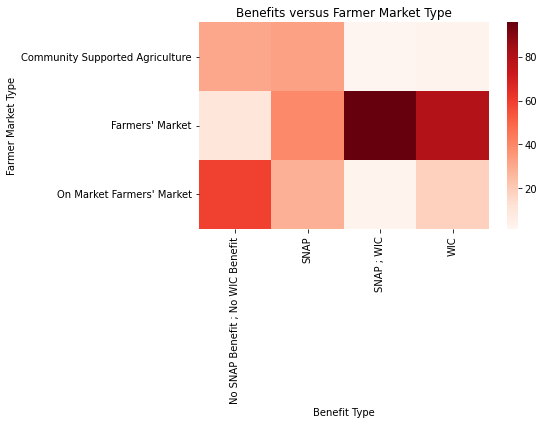

In [329]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 6))

sns.heatmap(benefit_markt_ct, cmap = 'Reds')
plt.xticks(rotation = 90)
plt.title("Benefits versus Farmer Market Type")
plt.tight_layout()
plt.savefig('fm_benefit.jpg', dpi = 200)
plt.show()

In [303]:
benefit_state_ct = pd.crosstab(index = gpd_df['State_name'], columns= gpd_df['Benefit Type'], normalize = 'columns')*100

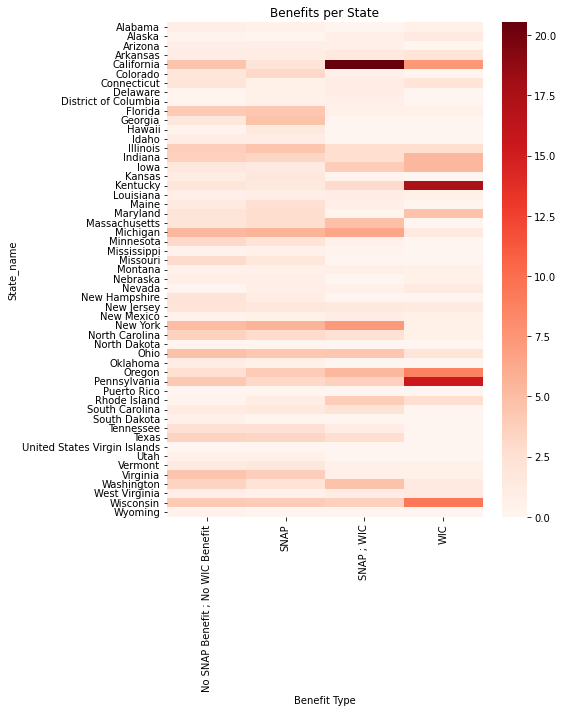

In [330]:
plt.figure(figsize = (8, 10))

sns.heatmap(benefit_state_ct, cmap = 'Reds')
plt.xticks(rotation = 90)
plt.title("Benefits per State")
plt.tight_layout()
plt.savefig('state_benefit.jpg', dpi = 200)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d013c1f-8c0f-427d-b5d7-5d9eb129596b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>